In [1]:
from os import listdir
from os.path import isdir
import numpy as np
from tkinter import *
from numpy import load
from numpy import expand_dims
from numpy import savez_compressed
from numpy import asarray
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import choice
import cv2
import dlib
from imutils import face_utils
from PIL import Image
font = cv2.FONT_HERSHEY_SIMPLEX
from keras.models import load_model
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
import openpyxl
from tkinter.filedialog  import askopenfilename


Using TensorFlow backend.


In [14]:
def face_detection(gray):
    face_detect = dlib.get_frontal_face_detector()
    rects = face_detect(gray, 1)
    pixels = asarray(gray)
    num=0
    required_size=(160, 160)
    faces = list()
    for (i, rect) in enumerate(rects):
        (x1, y1, w, h) = face_utils.rect_to_bb(rect)
        x1, y1 = abs(x1), abs(y1)
        cv2.rectangle(gray, (x1, y1), (x1 + w, y1 + h), (255, 255, 255), 3)
        x2, y2 = x1 + w, y1 + h
        face = pixels[y1:y2,x1:x2]
        image = Image.fromarray(face)
        image = image.resize(required_size)
        image = image.convert('RGB')
        face = asarray(image)
        faces.append(face)
        roi_color = gray[y1:y1+h,x1:x1+w]
        cv2.imwrite('C:/Users/Akhil/dest/pic'+str(num)+'.jpg', roi_color)
        num+=1
    plt.figure(figsize=(12,8))
    plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
    cv2.imwrite('C:/Users/Akhil/dest/pic'+str(num)+'.jpg', gray)
    plt.show()
    facearray = asarray(faces)
    np.savez_compressed('class-group.npz', facearray)

In [4]:
def extract_embeddings():
    def get_embedding(model, face_pixels):
        face_pixels = face_pixels.astype('float32')
        mean, std = face_pixels.mean(), face_pixels.std()
        face_pixels = (face_pixels - mean) / std
        samples = expand_dims(face_pixels, axis=0)
        yhat = model.predict(samples)
        return yhat[0]
    data = np.load('class-group.npz')
    trainX = data['arr_0']
    model = tf.keras.models.load_model('facenet_keras.h5')
    newTrainX = list()
    for face_pixels in trainX:
        embedding = get_embedding(model, face_pixels)
        newTrainX.append(embedding)
    newTrainX = asarray(newTrainX)
    savez_compressed('class-group-embeddings.npz', newTrainX)

In [19]:
def face_recognition_and_marking():
    wb = openpyxl.Workbook() 
    sheet = wb.active 
    sheet.title = "Attendance"
    my_dict={'Afreen':1, 'Akhil':2 , 'Latha':3,'Karthik':4,'Pranathi':5,'Roshan':6,'Samhitha':7,'Sharath':8,'Shashi':9,'Soumya':10,'Sreelekha':11,'Srija':12,'Srilatha':13,'Suchitra':14,'Sumanth':15,'Tejaswini':17,'B.Akhil':19,'Suraj':20,'Yashaswi':21}
    for x in my_dict:
        c1 = sheet.cell(row = my_dict[x], column = 1) 
        c1.value = x
        c2 = sheet.cell(row = my_dict[x], column = 2) 
        c2.value = "Absent"
    data = np.load('faces-dataset.npz')
    testX_faces = data['arr_2']
    data = np.load('faces-embeddings.npz')
    trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
    in_encoder = Normalizer(norm='l2')
    trainX = in_encoder.transform(trainX)
    testX = in_encoder.transform(testX)
    out_encoder = LabelEncoder()
    out_encoder.fit(trainy)
    trainy = out_encoder.transform(trainy)
    testy = out_encoder.transform(testy)
    model = SVC(kernel='linear', probability=True)
    model.fit(trainX, trainy)
    data2 = np.load('class-group.npz')
    testX2_faces = data2['arr_0']
    data2 = np.load('class-group-embeddings.npz')
    testX2 = data2['arr_0']
    selection = choice([i for i in range(testX.shape[0])])
    for i in range(testX2.shape[0]):
        random_face_pixels = testX2_faces[i]
        random_face_emb = testX2[i]
        samples = expand_dims(random_face_emb, axis=0)
        yhat_class = model.predict(samples)
        yhat_prob = model.predict_proba(samples)
        class_index = yhat_class[0]
        class_probability = yhat_prob[0,class_index] * 100
        predict_names = out_encoder.inverse_transform(yhat_class)
        print('Predicted: %s' % (predict_names[0]))
        row_number = my_dict[predict_names[0]]
        c1 = sheet.cell(row = row_number, column = 2) 
        c1.value = "Present"
        pyplot.subplot(3,8,i+1)
        pyplot.axis('off')
        pyplot.imshow(cv2.cvtColor(random_face_pixels, cv2.COLOR_BGR2RGB))
    #title = '%s (%.3f)' % (predict_names[0], class_probability)
    #pyplot.title(title)
    wb.save("C:\\Users\\Akhil\\Desktop\\Attendance.xlsx") 
    pyplot.show()

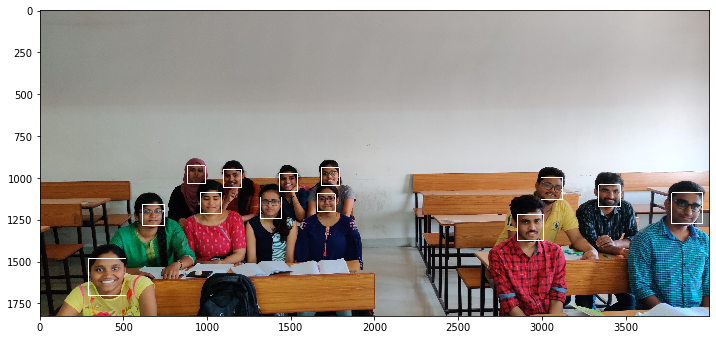

Loaded:  (13, 160, 160, 3)
Loaded Model
Predicted: Srilatha
Predicted: Suchitra
Predicted: Yashaswi
Predicted: Pranathi
Predicted: Srilatha
Predicted: Roshan
Predicted: Soumya
Predicted: Samhitha
Predicted: Tejaswini
Predicted: Srija
Predicted: Shashi
Predicted: Suraj
Predicted: Karthik


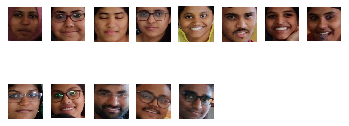

Done


In [21]:
name= askopenfilename() 
gray = cv2.imread(name, 1)
face_detection(gray)
extract_embeddings()
face_recognition_and_marking()
print("Done")
mainloop()